In [37]:
%load_ext autoreload
%autoreload 2
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras

import numpy as np

from distributions import ZeroInflatedDist, QuantizedNormal
from plotting_funcs import sample_and_plot, plot_dist, plot_hexagon_grid

import tensorflow as tf
import tensorflow_probability as tfp

from functools import partial

seed = 360
seedstep = 0


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


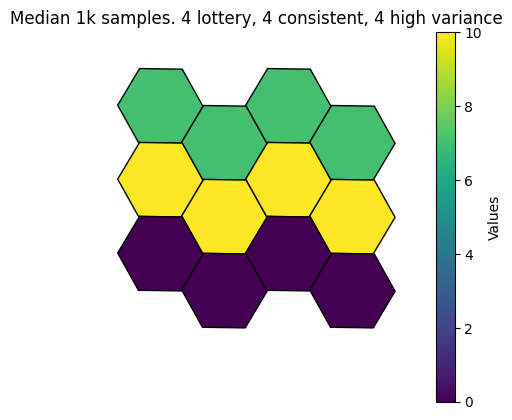

In [38]:
consistent_4 = [QuantizedNormal(7, 0.1) for _ in range(4)]

highvar_4 = [ZeroInflatedDist(QuantizedNormal(10, 0.1), 1-0.7) for _ in range(4)]

powerball_4 = [ZeroInflatedDist(QuantizedNormal(100, 0.1), 0.9) for _ in range(4)]
dist_S = consistent_4 + highvar_4 +powerball_4
S=12
sample_and_plot(dist_S, size=1000, median=True, title='Median 1k samples. 4 lottery, 4 consistent, 4 high variance')

In [39]:
def make_data(dist_S, H=50, T=500, seed=360):
    """Generate data from a list of distributions.
    
    Args:
        dist_S: list of distributions
        H: number of historical observations to be used as features
        T: number of timepoints
        seed: random seed
    Returns
        X_THS: numpy array of shape (T, H, S)
        y_TS: numpy array of shape (T, S)
    """

    # In order to have T timepoints each with H historical observations, we need T+H samples 
    data_HT_S = np.zeros((H+T, S))
    for s, dist in enumerate(dist_S):
        random_state = np.random.RandomState(10000 * seed + s)
        data_HT_S[:, s] = dist.rvs(size=H+T, random_state=random_state)

    X_THS = np.array([data_HT_S[t:H+t,:] for t in range(T)], dtype=np.float32)
    y_TS = np.array([data_HT_S[H+t, :] for t in range(T)], dtype=np.float32)

    return X_THS, y_TS

In [40]:
H = 50
T= 500

X_THS, y_TS = make_data(dist_S, H=H, T=T, seed=360)

# check that each final history is equal to the previous observation
for t in range(H, T):
    assert(np.all(X_THS[t, H-1, :] == y_TS[t-1, :]))

# check random point in history
for t in range(H, T):
    h = np.random.randint(0, H)
    assert(np.all(X_THS[t, h, :] == y_TS[t-(H-h), :]))

In [41]:
keras.utils.set_random_seed(seed+1000*seedstep)
seedstep += 1
# Build our GLM. Use 1D convolution over the history dimension to make our linear model
model = keras.Sequential(
    [
        keras.layers.Input(shape=(H, S)),
        # convolution to turn H,S into 1,S
        # Filters = size oute convolutiput space
        # kernel_size = size of thon window
        # dataformat = channels_first means that the input shape is (batch_size, features, time)
        keras.layers.Conv1D(filters=1, kernel_size=1, activation='softplus', data_format='channels_first'),
        keras.layers.Flatten(),
    ]
)

In [42]:
model.trainable_variables

[<tf.Variable 'conv1d_1/kernel:0' shape=(1, 50, 1) dtype=float32, numpy=
 array([[[ 0.09135124],
         [-0.13052313],
         [-0.06926462],
         [ 0.18495086],
         [-0.24233642],
         [-0.30410433],
         [ 0.08536297],
         [ 0.2500011 ],
         [ 0.29269716],
         [-0.19647978],
         [-0.25835374],
         [-0.19405591],
         [-0.14992085],
         [-0.18116142],
         [-0.19185841],
         [-0.04854104],
         [ 0.18115577],
         [ 0.15043491],
         [ 0.08193448],
         [-0.19558229],
         [ 0.06266752],
         [-0.05227694],
         [-0.0575504 ],
         [-0.05991924],
         [-0.24248657],
         [-0.2328073 ],
         [ 0.02847317],
         [ 0.05511755],
         [ 0.33605054],
         [ 0.13111478],
         [-0.3313339 ],
         [-0.18981145],
         [-0.13934882],
         [ 0.2558885 ],
         [ 0.2096459 ],
         [-0.21492727],
         [ 0.02145621],
         [-0.24753344],
         [-0.21

our log likelihood becomes:
$$\log p(y_s,t| \boldsymbol{x}_{s,t}) = y_{s,t} \log {\hat{y_{s,t}}} - \hat{y_{s,t}} - \log(y_{s,t}!)$$


In [43]:
def poisson_nll(y_true, y_pred):
    """Poisson negative log likelihood loss function.
    
    Args:
        y_true: true values
        y_pred: predicted values
    Returns:
        negative log likelihood
    """
    return y_pred - y_true * tf.math.log(y_pred + 1e-10)

In [44]:
preds_TS = model.predict(X_THS)

16/16 [==============================] - 0s 948us/step


In [45]:
my_poisson_nll = poisson_nll(y_TS, preds_TS).numpy()
tf_poisson_nll = tf.nn.log_poisson_loss(targets=y_TS, log_input=tf.math.log(preds_TS+ 1e-10)).numpy()
assert(np.allclose(my_poisson_nll, tf_poisson_nll, atol=1e-9))

In [46]:
from perturbations.perturbations import perturbed

In [47]:
def top_k_idx(input_BD, **kwargs):
    _, idx_BD = tf.math.top_k(input_BD, **kwargs)
    input_depth = input_BD.shape[-1]
    one_hot_idx_BKD = tf.one_hot(idx_BD, input_depth)
    # Sum over k dimension so we dont have to worry about sorting
    k_hot_idx_BD = tf.reduce_sum(one_hot_idx_BKD, axis=-2)

    return k_hot_idx_BD

In [48]:
np.sum(my_poisson_nll)

601567.6

In [49]:
K=3
top_K_idx_func = partial(top_k_idx, k=K)

perturbed_top_K = perturbed(top_K_idx_func,
                                num_samples=1000,
                                sigma=1,
                                noise='normal',
                                batched=True)

In [50]:
def negative_bpr_K_uncurried(y_true, y_pred, K=3, perturbed_top_K_func=None):
    
    top_K_ids = perturbed_top_K_func(y_pred)
    true_top_K_val, true_top_K_idx = tf.math.top_k(y_true, k=K)
    denominator = tf.reduce_sum(true_top_K_val, axis=-1)
    numerator = tf.reduce_sum(top_K_ids * y_true, axis=-1)
    loss_val = tf.reduce_mean(-numerator/denominator)

    return loss_val

negative_bpr_K = partial(negative_bpr_K_uncurried,K=K, perturbed_top_K_func=perturbed_top_K)

In [51]:
top_K_ids = top_K_idx_func(X_THS)
perturbed_top_K_ids = perturbed_top_K(X_THS)

In [52]:
top_K_ids[0,0,:]

<tf.Tensor: shape=(12,), dtype=float32, numpy=array([0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.], dtype=float32)>

In [53]:
X_THS[0,0,:]

array([ 7.,  7.,  7.,  7., 10.,  0., 10., 10.,  0.,  0.,  0.,  0.],
      dtype=float32)

In [54]:
perturbed_top_K_ids[0,0,:]

<tf.Tensor: shape=(12,), dtype=float32, numpy=
array([0.039, 0.043, 0.043, 0.044, 0.946, 0.   , 0.937, 0.948, 0.   ,
       0.   , 0.   , 0.   ], dtype=float32)>

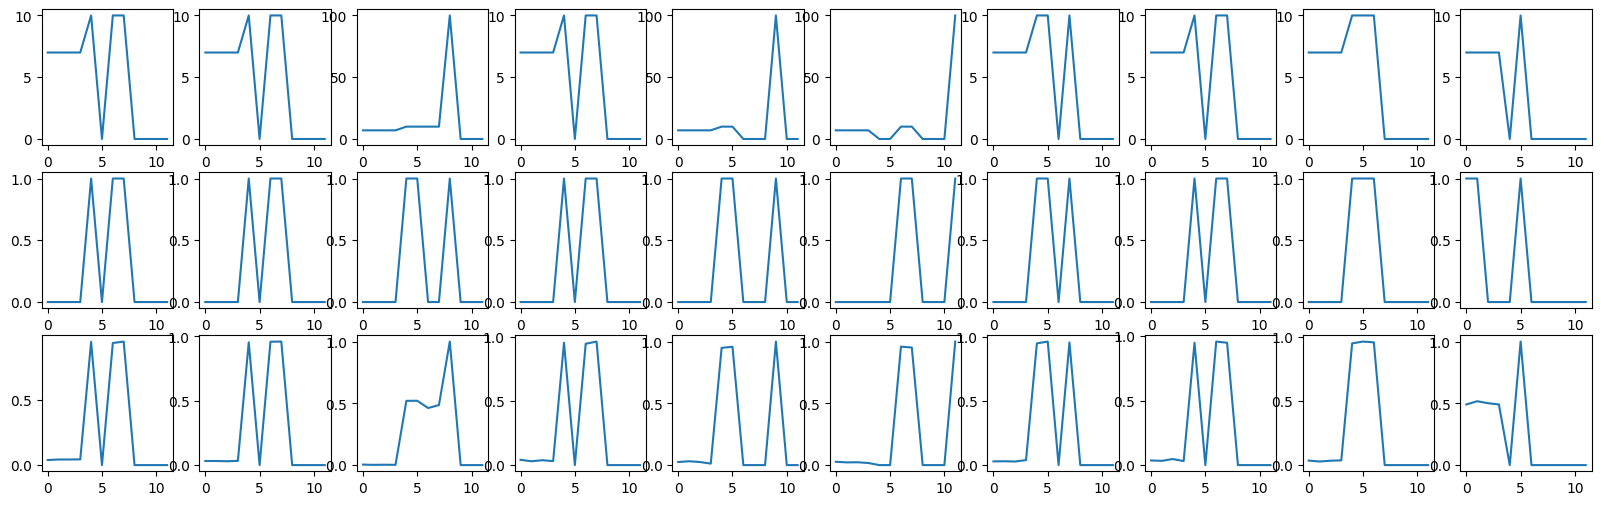

In [55]:
# plot 3x10 squares of X, top3 and perturbed top3
from matplotlib import pyplot as plt
plt.figure(figsize=(20, 6))
for i in range(10):
    plt.subplot(3, 10, i+1)
    plt.plot(X_THS[0, i, :])
    plt.subplot(3, 10, i+11)
    plt.plot(top_K_ids[0, i, :])
    plt.subplot(3, 10, i+21)
    plt.plot(perturbed_top_K_ids[0, i, :])

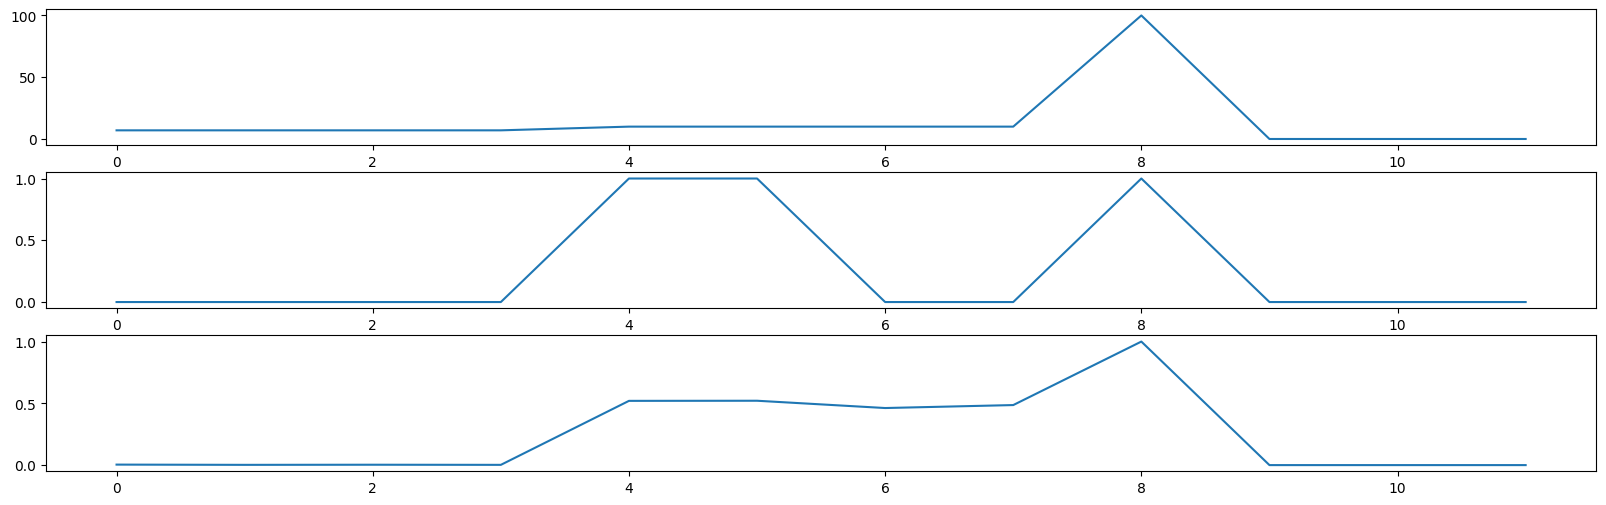

In [56]:
# plot X, top3, and perturbed top 3 for a single timepoint
i=2
plt.figure(figsize=(20, 6))
plt.subplot(3, 1, 1)
plt.plot(X_THS[0, i, :])
plt.subplot(3, 1, 2)
plt.plot(top_K_ids[0, i, :])
plt.subplot(3, 1, 3)
plt.plot(perturbed_top_K_ids[0, i, :])


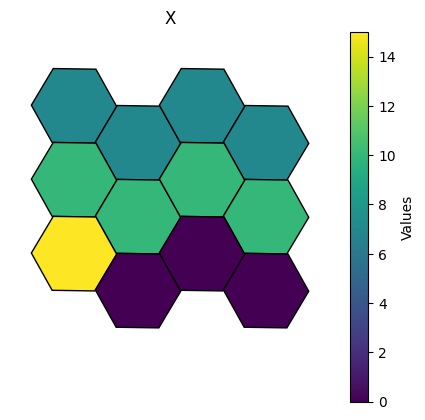

In [57]:
plot_hexagon_grid(X_THS[0, i, :], title='X', vmax=15)

In [58]:
X_train = X_THS[:300, :, :]
y_train = y_TS[:300, :] 
X_val = X_THS[300:400, :, :]
y_val = y_TS[300:400, :]
X_test = X_THS[400:, :, :]
y_test = y_TS[400:, :]

In [59]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024, seed=seed+seedstep*1000).batch(32)
seedstep += 1

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(32)

In [60]:
# calculate val bpr and nll
val_preds = model.predict(X_val)
val_nll = poisson_nll(y_val, val_preds).numpy()
val_bpr = negative_bpr_K(y_val, val_preds).numpy()

print('Val NLL: ', np.mean(val_nll))
print('Val BPR: ', val_bpr)

4/4 [==============================] - 0s 2ms/step
Val NLL:  105.180244
Val BPR:  -0.35233387


In [61]:
val_nll.shape

(100, 12)

In [62]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)

In [63]:
model.compile(optimizer=optimizer, loss=poisson_nll)

In [29]:
model.fit(train_dataset, epochs=100, validation_data=val_dataset)

Epoch 1/100


10/10 [==============================] - 0s 9ms/step - loss: 39.2788 - val_loss: 14.4611
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 8.6908 - val_loss: 13.0682
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 9.5160 - val_loss: 11.4479
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 6.2039 - val_loss: 8.8519
Epoch 5/100
10/10 [==============================] - 0s 3ms/step - loss: 2.2476 - val_loss: 8.4846
Epoch 6/100
10/10 [==============================] - 0s 3ms/step - loss: -0.1160 - val_loss: 8.6862
Epoch 7/100
10/10 [==============================] - 0s 3ms/step - loss: -1.7368 - val_loss: 7.6280
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: -2.4573 - val_loss: 6.7564
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: -3.2817 - val_loss: 6.2584
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: -3.8190 - val_loss: 4.9780
Epoch 11/100

In [66]:
# calculate val bpr and nll
val_preds = model.predict(X_val)
val_nll = poisson_nll(y_val, val_preds).numpy()
val_bpr = negative_bpr_K(y_val, val_preds).numpy()

print('Val NLL: ', np.mean(val_nll))
print('Val BPR: ', val_bpr)

4/4 [==============================] - 0s 1ms/step
Val NLL:  165.43967
Val BPR:  -0.4030628


In [65]:
epochs = 100
for epoch in range(epochs):
    print('Epoch: ', epoch)
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            preds = model(x_batch_train, training=True)
            loss = negative_bpr_K(y_batch_train, preds)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        #if step % 10 == 0:
        #    print('Training loss (for one batch) at step %s: %s' % (step, float(loss)))
        #    print('Seen so far: %s samples' % ((step + 1) * 32))

    val_preds = model.predict(X_val)
    val_nll = poisson_nll(y_val, val_preds).numpy()
    val_bpr = negative_bpr_K(y_val, val_preds).numpy()

    print('Val NLL: ', np.mean(val_nll))
    print('Val BPR: ', val_bpr)

Epoch:  0
4/4 [==============================] - 0s 1ms/step
Val NLL:  123.0231
Val BPR:  -0.34989876
Epoch:  1
4/4 [==============================] - 0s 1ms/step
Val NLL:  135.99341
Val BPR:  -0.35531983
Epoch:  2
4/4 [==============================] - 0s 1ms/step
Val NLL:  148.68727
Val BPR:  -0.3654258
Epoch:  3
4/4 [==============================] - 0s 1ms/step
Val NLL:  154.59409
Val BPR:  -0.3813314
Epoch:  4
4/4 [==============================] - 0s 1ms/step
Val NLL:  156.00844
Val BPR:  -0.38675278
Epoch:  5
4/4 [==============================] - 0s 1ms/step
Val NLL:  157.32129
Val BPR:  -0.38966137
Epoch:  6
4/4 [==============================] - 0s 1ms/step
Val NLL:  158.23949
Val BPR:  -0.38737258
Epoch:  7
4/4 [==============================] - 0s 1ms/step
Val NLL:  157.09299
Val BPR:  -0.3820737
Epoch:  8
4/4 [==============================] - 0s 1ms/step
Val NLL:  158.25061
Val BPR:  -0.3979205
Epoch:  9
4/4 [==============================] - 0s 1ms/step
Val NLL:  158.090

In [63]:
top_K_ids * y_batch_train

<tf.Tensor: shape=(32, 12), dtype=float32, numpy=
array([[9.7299999e-01, 8.8900006e-01, 9.7299999e-01, 1.0220000e+00,
        0.0000000e+00, 1.4999999e-01, 0.0000000e+00, 5.1999998e-01,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [3.0100000e-01, 2.8700000e-01, 3.2900000e-01, 2.5199997e-01,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 8.6300001e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [7.7700001e-01, 7.5600004e-01, 6.6499996e-01, 6.5799999e-01,
        9.0999997e-01, 2.0000001e-02, 3.4000001e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [4.7600001e-01, 4.0599999e-01, 3.3600000e-01, 4.2700002e-01,
        0.0000000e+00, 2.0000001e-02, 7.6399999e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [4.4800001e-01, 3.9200002e-01, 5.1099998e-01, 4.2700002e-01,
        0.0000000e+00, 0.0000000e+00, 8.9999996e-02, 3.7000000

In [64]:
-numerator/denominator

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([-0.16766666, -0.40829167, -0.23953333, -0.31016666, -0.08288889,
       -0.8661    , -0.        , -0.3158333 , -0.        , -0.8882667 ,
       -0.07125926, -0.23696667, -0.15583333, -0.86013335, -0.003     ,
       -0.80875003, -0.43576667, -0.5618889 , -0.01296296, -0.6106296 ,
       -0.18506667, -0.00236667, -0.33      , -0.03207408, -0.        ,
       -0.20125926, -0.8333333 , -0.56983334, -0.59650004, -0.2827778 ,
       -0.10918518, -0.8635333 ], dtype=float32)>

In [32]:
val_preds.shape

(100, 12)

In [67]:
# get one hot vector of top 3 values in val_preds
top_K_ids = top_K_idx_func(val_preds)
np.mean(top_K_ids, axis=0)

In [68]:
np.mean(top_K_ids, axis=0)

array([0.12, 0.01, 0.  , 0.  , 0.63, 0.23, 0.23, 0.28, 0.35, 0.3 , 0.35,
       0.5 ], dtype=float32)

In [71]:
# create a 100x12 tensor where the first 3 columns are 1 and the rest are 0
first_3 = np.zeros((100, 12))
first_3[:, :3] = 1

In [72]:
# calculate nll and bpr for first 3
nll_first_3 = poisson_nll(y_val, first_3).numpy()
bpr_first_3 = negative_bpr_K(y_val, first_3).numpy()
print('First 3 NLL: ', np.mean(nll_first_3))
print('First 3 BPR: ', bpr_first_3)

First 3 NLL:  133.6080533023968
First 3 BPR:  -0.47911656
